In [ ]:
%%capture
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import time
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

!pip install transformers

from transformers import  AutoTokenizer, BertTokenizer,  AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) #Todos os valore e vetores são carregados na gpu, caso ela esteja disponível

In [ ]:
%%capture
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased').to(device)

In [ ]:
model

In [ ]:
def get_data(nome_arquivo,shuffle):
    ds = pd.read_csv(nome_arquivo,encoding="utf-8")
    if shuffle:
        ds = ds.sample(frac=1)
    ds['texto'] = ds['texto'].apply(str)
    return ds

stop = set(stopwords.words("portuguese"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"",text)

def remove_punct(text):
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    return text.translate(translator)

def remove_numbers(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

def remove_hifen(text):
    translator = str.maketrans('-',' ')
    return text.translate(translator)

pattern = re.compile(r"https?//(\S+|www)\.\S+")
def pat(df_t):
    for t in df_t.texto:
        matches = pattern.findall(t)
        for match in  matches:
            print(t)
            print(match)
            print(pattern.sub(r"",t))        
        if len(matches)> 0:
            break

def make_test(df_t):
    df_t["texto"] = df_t.texto.map(remove_URL)
    df_t["texto"] = df_t.texto.map(remove_punct)
    df_t["texto"] = df_t.texto.map(remove_hifen)
    #df_t["texto"] = df_t.texto.map(remove_numbers)
    df_t["texto"] = df_t.texto.map(remove_stopwords)

def prepare(teste):
    teste = remove_URL(teste)
    teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

#counter = counter_word(df.texto)  

def prepare(teste):
    teste = remove_URL(teste)
    #teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

In [ ]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self,X,y):
        self.X = X
        self.X = self.X.to(device)

        self.y = y
        self.y = self.y.to(device)

        self.len = len(y)

    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.X[:,idx],self.y[idx]

In [ ]:
train_size = 0.9
val_size = 0.1
BATCH = 18

In [ ]:
class ModeloMultiClass(nn.Module):
    def __init__(self,num_palavras:int, dimensao:int, classes:int, pretrained_model):

        super(ModeloMultiClass, self).__init__()
        self.pretrained = pretrained_model 
        self.shape1 = nn.Linear(in_features = num_palavras * dimensao, out_features=768)
        self.shape2 = nn.Linear(768, out_features = 128)
        self.dense1 = nn.ReLU()
        self.shape5 = nn.Linear(128, out_features = classes)
        self.dense6 = nn.Dropout(0.01)

    def forward(self,input_ids,input_masks):
        """
        y = self.pretrained(input_ids,input_masks)
        y = y[0].flatten(start_dim=1)
        y = self.shape1(y)
        y = self.shape2(y)
        y = self.dense1(y)
        y = self.shape5(y)
        y = self.dense6(y)  
        """
        y = self.pretrained(input_ids,input_masks)
        y = y[0].flatten(start_dim=1)
        y = F.relu(self.shape1(y))
        y = F.relu(self.shape2(y))
        y = F.dropout(self.shape5(y),p=0.01)
        return y

In [ ]:
    """
        super(ModeloMultiClass, self).__init__()
        self.pretrained = pretrained_model 
        self.shape1 = nn.Linear(in_features = num_palavras * dimensao, out_features=768)
        self.shape2 = nn.Linear(768, out_features = 1400)
        self.shape3 = nn.Linear(1400, out_features = 144)
        self.shape4 = nn.Linear(144, out_features = 128)
        self.shape5 = nn.Linear(128, out_features = classes)

    def forward(self,input_ids,input_masks):
        y = self.pretrained(input_ids,input_masks)
        y = y[0].flatten(start_dim=1)
        y = F.relu(self.shape1(y))
        y = F.relu(self.shape2(y))
        y = F.relu(self.shape3(y))
        y = F.relu(self.shape4(y))
        y = F.dropout(self.shape5(y),p=0.01)
        return y
    """

'\n    super(ModeloMultiClass, self).__init__()\n    self.pretrained = pretrained_model \n    self.shape1 = nn.Linear(in_features = num_palavras * dimensao, out_features=768)\n    self.shape2 = nn.Linear(768, out_features = 1400)\n    self.shape3 = nn.Linear(1400, out_features = 144)\n    self.shape4 = nn.Linear(144, out_features = 128)\n    self.shape5 = nn.Linear(128, out_features = classes)\n\ndef forward(self,input_ids,input_masks):\n    y = self.pretrained(input_ids,input_masks)\n    y = y[0].flatten(start_dim=1)\n    y = F.relu(self.shape1(y))\n    y = F.relu(self.shape2(y))\n    y = F.relu(self.shape3(y))\n    y = F.relu(self.shape4(y))\n    y = F.dropout(self.shape5(y),p=0.01)\n    return y\n'

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
modelo = ModeloMultiClass(150,768,9,model).to(device)

In [ ]:
train = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo3/train.csv'
eval = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo3/eval.csv'

In [ ]:
df = get_data(train,1)
dt = get_data(eval,0)

pat(df)
make_test(df)
pat(dt)
make_test(dt)

df_tok = tokenizer.batch_encode_plus(df['texto'].tolist(), max_length=150, truncation= True, padding="max_length", 
                                  add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'pt')

dt_tok = tokenizer.batch_encode_plus(dt['texto'].tolist(), max_length=150, truncation= True, padding="max_length", 
                                  add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'pt')

X = torch.stack((df_tok['input_ids'],df_tok['attention_mask']),dim=0)
X_test = torch.stack((dt_tok['input_ids'],dt_tok['attention_mask']),dim=0)

y = torch.Tensor(df['valor'].to_numpy())
y_test = torch.Tensor(dt['valor'].to_numpy())

dataset = MyDataset(X,y)
teste_dataset = MyDataset(X_test,y_test)

n_train = int(np.round(dataset.len*train_size))
n_val = int(np.round(dataset.len*val_size))

train_slice, val_slice = torch.utils.data.random_split(dataset,[n_train,n_val])

train_loader = torch.utils.data.DataLoader(train_slice,batch_size=BATCH,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_slice,batch_size=BATCH,shuffle=True)

test_loader = torch.utils.data.DataLoader(teste_dataset,batch_size=1,shuffle=False)

In [ ]:
df.shape

(1420, 2)

In [ ]:
print((df.valor==1).sum()," textos de Eletronica")#eletronica
print((df.valor==2).sum()," textos de Direito")#direito
print((df.valor==3).sum()," textos de Eletrica")#eletrica
print((df.valor==4).sum()," textos de Odontologia")#odontologia
print((df.valor==5).sum()," textos de Computação")#computação
print((df.valor==6).sum()," textos de Geografia")#geografia
print((df.valor==7).sum()," textos de Ambiental")#ambiental
print((df.valor==8).sum()," textos de Mecanica")#mecanica

200  textos de Eletronica
198  textos de Direito
200  textos de Eletrica
103  textos de Odontologia
120  textos de Computação
199  textos de Geografia
200  textos de Ambiental
200  textos de Mecanica


In [ ]:
y.size()

torch.Size([1420])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modelo.parameters(),lr=1e-6)
acc_calc = lambda output,labels : (labels == output.argmax(axis = 1)).sum()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim,0.9992)


In [ ]:
epocas = 40
steps = 200
validation = 20

In [ ]:
hist_train_acc = []
hist_train_loss = []
hist_val_acc = []
hist_val_loss = []

for i in range(epocas):
  n_train_ex = 0
  n_val_ex = 0

  train_hit = 0
  val_hit = 0
  for step, (data,labels) in enumerate(train_loader):
    modelo.train()
    train_loss = 0

    input_ids,input_masks = data[:,0,:], data[:,1,:]  

    output = modelo(input_ids,input_masks)
    
    optim.zero_grad()
    loss_train = loss_fn(output,labels.long())

    train_loss += loss_train.item()
    softmax_pred = nn.functional.softmax(output,dim=1)
    train_hit +=  acc_calc(softmax_pred,labels)  
  
    loss_train.backward()
    optim.step()

    n_train_ex += data.shape[0]

    if (step + 1) % steps == 0:
          #train_bar.close()
          break
    
    scheduler.step()
  
    
  for step, (val_data,val_labels) in enumerate(val_loader):    
    with torch.no_grad():
        modelo.eval()
        val_loss = 0

        t_input_ids,t_input_masks = val_data[:,0,:], val_data[:,1,:]  

        output_val  = modelo(t_input_ids,t_input_masks)
        loss_val = loss_fn(output_val,val_labels.long())   

        val_loss += loss_val.item()
        softmax_pred2 = nn.functional.softmax(output_val,dim=1)
        val_hit += acc_calc(softmax_pred2,val_labels)

        #val_bar.update(1)

        n_val_ex += data.shape[0]
        if (step + 1) % validation == 0:
          #train_bar.close()
          break   

  train_acc = torch.true_divide(train_hit,n_train_ex)
  val_acc = torch.true_divide(val_hit,n_val_ex)

  print(f'\nÉPOCA - {i+1}\t Train loss: {round(train_loss,4)}\t Train Acc: {round(train_acc.item(),4)}\t Val loss:{round(val_loss,4)}\t Val Acc: {round(val_acc.item(),4)}')
  
  hist_train_acc.append(train_acc.item())
  hist_train_loss.append(train_loss)
  hist_val_acc.append(val_acc.item())
  hist_val_loss.append(val_loss)


ÉPOCA - 1	 Train loss: 2.0746	 Train Acc: 0.2019	 Val loss:2.146	 Val Acc: 0.2639

ÉPOCA - 2	 Train loss: 2.025	 Train Acc: 0.4116	 Val loss:2.0273	 Val Acc: 0.3889

ÉPOCA - 3	 Train loss: 1.5831	 Train Acc: 0.6244	 Val loss:1.7803	 Val Acc: 0.5347

ÉPOCA - 4	 Train loss: 1.5394	 Train Acc: 0.741	 Val loss:1.5113	 Val Acc: 0.6042

ÉPOCA - 5	 Train loss: 1.3612	 Train Acc: 0.7786	 Val loss:1.623	 Val Acc: 0.6319

ÉPOCA - 6	 Train loss: 1.1877	 Train Acc: 0.8122	 Val loss:1.6455	 Val Acc: 0.6181

ÉPOCA - 7	 Train loss: 1.1369	 Train Acc: 0.8075	 Val loss:1.3723	 Val Acc: 0.6667

ÉPOCA - 8	 Train loss: 0.8141	 Train Acc: 0.8232	 Val loss:1.1754	 Val Acc: 0.6458

ÉPOCA - 9	 Train loss: 0.9501	 Train Acc: 0.8255	 Val loss:1.4818	 Val Acc: 0.6667

ÉPOCA - 10	 Train loss: 0.9227	 Train Acc: 0.849	 Val loss:1.0514	 Val Acc: 0.6806

ÉPOCA - 11	 Train loss: 0.9403	 Train Acc: 0.8451	 Val loss:0.936	 Val Acc: 0.6875

ÉPOCA - 12	 Train loss: 0.7022	 Train Acc: 0.856	 Val loss:1.2791	 Val Acc: 0.6

In [ ]:
hist_epoca = np.arange(1,epocas+1,1)

In [ ]:
hist_epoca.size

40

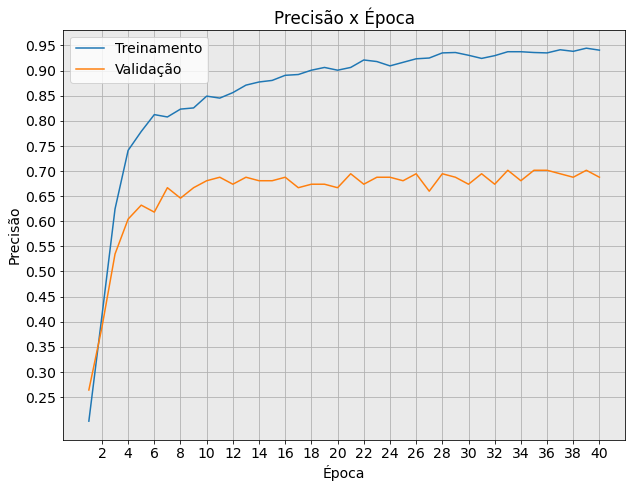

In [ ]:
hist_train = pd.DataFrame({"Precisão":hist_train_acc,"Época":hist_epoca})
hist_val = pd.DataFrame({"Precisão":hist_val_acc,"Época":hist_epoca})
plt.rcParams["figure.figsize"] = [9.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.titleweight"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
ax = sns.lineplot(x = "Época", y = "Precisão",data= hist_train)
ax.set_facecolor('#EAEAEA')
ax1 = sns.lineplot(x = "Época", y = "Precisão",data= hist_val)
plt.legend(labels=['Treinamento', 'Validação'])
plt.yticks(np.arange(0.25,1,0.05))
x = np.arange(1,epocas+1,1)
#plt.xticks(x,hist_train['Época'])
plt.xticks(np.arange(2,epocas+1,2))
plt.title("Precisão x Época")
plt.grid()
#plt.suptitle("Precisão x Época",fontweight='bold')
plt.show()

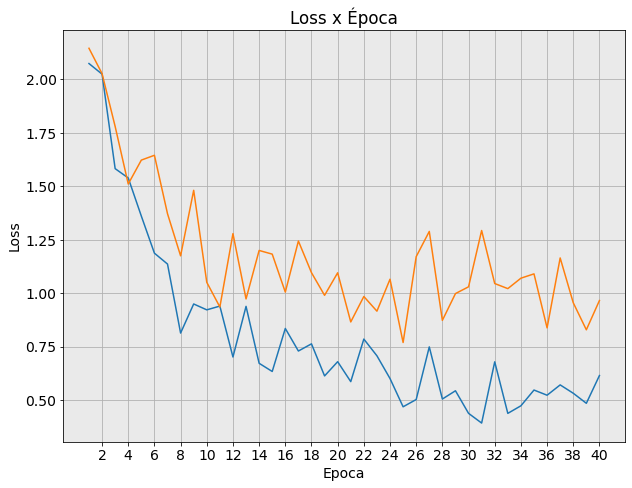

In [ ]:

hist_train_l = pd.DataFrame({"Loss":hist_train_loss,"Epoca":hist_epoca})
hist_val_l = pd.DataFrame({"Loss":hist_val_loss,"Epoca":hist_epoca})
plt.rcParams["figure.figsize"] = [9.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.titleweight"] = 10
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
ax = sns.lineplot(x = "Epoca", y = "Loss",data= hist_train_l)
ax.set_facecolor('#EAEAEA')
ax1 = sns.lineplot(x = "Epoca", y = "Loss",data= hist_val_l)
plt.title("Loss x Época")
x = np.arange(1,11,1)
#plt.xticks(x,hist_epoca)
plt.xticks(np.arange(2,epocas+1,2))
#plt.yticks(np.arange(0.1,0.8,0.05))
plt.grid()
plt.show()

In [ ]:
disciplinas = {1:'Eletronica',2:"Direito",3:"Eletrica",4:'Odontologia',5:'Computação',6:'Geografia',7:'Ambiental',8:'Mecanica'}

In [ ]:
def predictions(text:str) -> str:
    text = prepare(text)
    batch = tokenizer(text,padding='max_length',max_length = 150,truncation = True,return_tensors='pt').to(device)
    
    with torch.no_grad():
        outputs = modelo(batch['input_ids'],batch['attention_mask'])
        #print(outputs)
        
        predictions = F.softmax(outputs,dim=1)
        #print(predictions)
        labels = torch.argmax(predictions,dim=1)
        #print(labels.item())
        return disciplinas.get(labels.item())  

In [ ]:
for label,text in zip(y_test,dt['texto']):
  res = predictions(text=text)
  print(f'Previsto: {res}\t Correto: {disciplinas.get(label.item())}')

Previsto: Eletronica	 Correto: Eletronica
Previsto: Eletronica	 Correto: Eletronica
Previsto: Direito	 Correto: Direito
Previsto: Direito	 Correto: Direito
Previsto: Eletrica	 Correto: Eletrica
Previsto: Eletrica	 Correto: Eletrica
Previsto: Odontologia	 Correto: Odontologia
Previsto: Odontologia	 Correto: Odontologia
Previsto: Computação	 Correto: Computação
Previsto: Computação	 Correto: Computação
Previsto: Geografia	 Correto: Geografia
Previsto: Geografia	 Correto: Geografia
Previsto: Ambiental	 Correto: Ambiental
Previsto: Ambiental	 Correto: Ambiental
Previsto: Ambiental	 Correto: Mecanica
Previsto: Mecanica	 Correto: Mecanica


In [ ]:
n_test_ex = 0
test_hits = 0
test_hit = []

test_loss = 0

for batch_num, (features,labels) in enumerate(test_loader):
        
        with torch.no_grad():
            val_loss = 0

            model.eval()

            input_ids,input_masks = features [:,0,:],features[:,1,:]

            outputs = modelo(input_ids,input_masks)

            loss = loss_fn(outputs,labels.long())

            test_loss += loss.item()

            softmax_pred = F.softmax(outputs,dim=1)
            test_hits += acc_calc(softmax_pred,labels)
            test_hit.append(acc_calc(softmax_pred,labels).item())

            n_test_ex += features.shape[0]


In [ ]:
test_acc = torch.true_divide(test_hits,n_test_ex)
test_acc

tensor(0.9375, device='cuda:0')

In [ ]:
test_hit,y_test

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 tensor([1., 1., 2., 2., 3., 3., 4., 4., 5., 5., 6., 6., 7., 7., 8., 8.]))